In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# String manipulation - from string to vector
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Neural network requirements
import tensorflow as tf
import keras 
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras import metrics
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, Dropout, Embedding
import joblib



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gltut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gltut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gltut\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Importing the dataset

In [15]:
df = pd.read_csv('data/dataset_classifier.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.dropna() # only 1 nan

### Top 10 used techniques

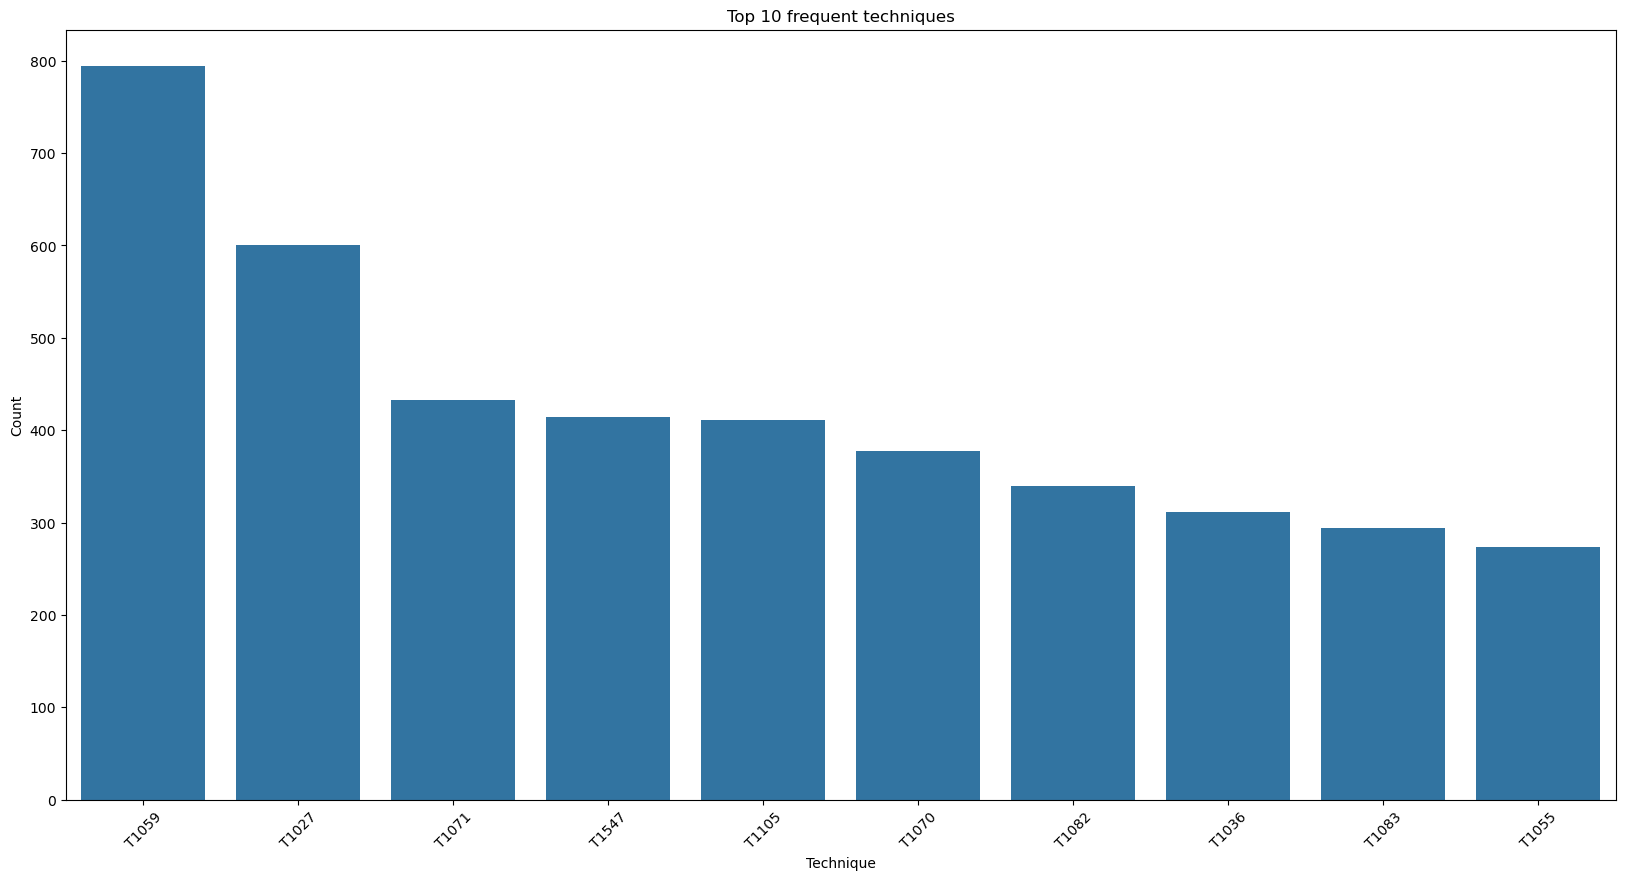

In [16]:
top_frequent_tec = df.groupby(['label_tec']).size().sort_values(ascending=False).reset_index(name='count').loc[:9]
plt.figure(figsize = (20,10))
sns.barplot(data = top_frequent_tec, x = 'label_tec', y = 'count')
plt.xlabel('Technique')
plt.ylabel('Count')
plt.title('Top 10 frequent techniques')
plt.xticks(rotation = 45)
plt.show()

# Transforming and tokenizing the text

In [17]:
lemma = WordNetLemmatizer()
s_words = stopwords.words('english')

def cleaning(row):
    row = re.sub(r'http\S+', '', row)

    row = re.sub("[^a-zA-Z0-9]", " ", row)

    row = nltk.word_tokenize(row.lower())

    row = [lemma.lemmatize(word) for word in row]

    row = [word for word in row if word not in s_words]

    row = " ".join(row)
    return row

df['MB'] = df['sentence'].apply(cleaning)


# Get the set of unique words in the dataset
words_un = []
for sentence in df['MB']:
    for word in sentence.split():
        if word.lower() not in words_un:
            words_un.append(word.lower())

voc_size = len(words_un)

max_sent_length = 512

print(f'Vocab_size: {voc_size}')
print(f'Maximum_Sentence_length: {max_sent_length}')


one_hot_train = [one_hot(words, voc_size) for words in df['MB']]
pad_train = pad_sequences(one_hot_train, padding = 'pre', maxlen = max_sent_length)

Vocab_size: 9342
Maximum_Sentence_length: 512


# Model definition

In [18]:
embedding_vector_features = 100
model = Sequential()

model.add(Embedding(voc_size, embedding_vector_features, input_length = max_sent_length))
model.add(Dropout(0.5))
model.add(LSTM(200))
model.add(Dropout(0.5))
model.add(Dense(190, activation = 'softmax')) 
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          934200    
                                                                 
 dropout (Dropout)           (None, 512, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 190)               38190     
                                                                 
Total params: 1,213,190
Trainable params: 1,213,190
Non-trainable params: 0
_________________________________________________________________


### Model visualization

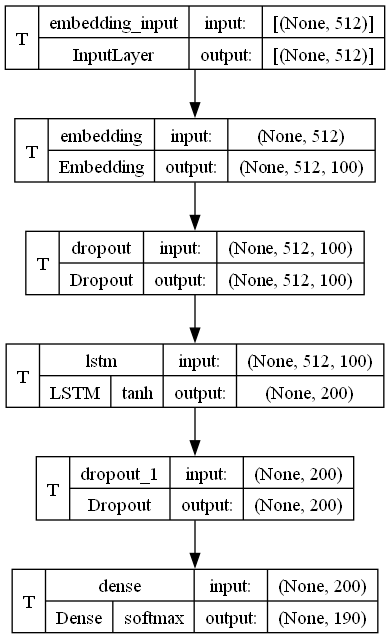

In [19]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    show_layer_activations=True,
    show_trainable=True,
)

# Prepare the target for multiclassification 

In [20]:
# Encoding MITRE techniques

encoder = LabelEncoder()
encoder.fit(df['label_tec'])
encoded_Y = encoder.transform(df['label_tec'])
joblib.dump(encoder, 'label_encoder.pkl')



y = to_categorical(encoded_Y)

# Training, Validation and Testing dataset

In [21]:
# Split dataset into training set, test set and validation set
X_train, X_test, y_train, y_test = train_test_split(pad_train, y, test_size=0.4, stratify=y, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=2)

In [24]:
X_test.shape

(2885, 512)

In [9]:
epochs_num = 30
# Neural network fitting
history = model.fit(X_train, y_train, batch_size=32, shuffle=True, epochs=epochs_num, validation_data=(X_val, y_val))
history_df  = pd.DataFrame(history.history)

Epoch 1/30
271/271 [==============================] - 292s 1s/step - loss: 4.6500 - accuracy: 0.0535 - val_loss: 4.3101 - val_accuracy: 0.0904
Epoch 2/30
271/271 [==============================] - 271s 999ms/step - loss: 3.9193 - accuracy: 0.1576 - val_loss: 3.4043 - val_accuracy: 0.2481
Epoch 3/30
271/271 [==============================] - 274s 1s/step - loss: 3.1374 - accuracy: 0.2917 - val_loss: 2.9129 - val_accuracy: 0.3448
Epoch 4/30
271/271 [==============================] - 270s 996ms/step - loss: 2.7293 - accuracy: 0.3695 - val_loss: 2.6161 - val_accuracy: 0.3999
Epoch 5/30
271/271 [==============================] - 277s 1s/step - loss: 2.3060 - accuracy: 0.4495 - val_loss: 2.3801 - val_accuracy: 0.4453
Epoch 6/30
271/271 [==============================] - 277s 1s/step - loss: 1.9990 - accuracy: 0.5165 - val_loss: 2.2557 - val_accuracy: 0.4716
Epoch 7/30
271/271 [==============================] - 281s 1s/step - loss: 1.7521 - accuracy: 0.5668 - val_loss: 2.1583 - val_accuracy: 

In [10]:
loss,acc = model.evaluate(X_test, y_test)

91/91 [==============================] - 15s 166ms/step - loss: 2.0837 - accuracy: 0.6128


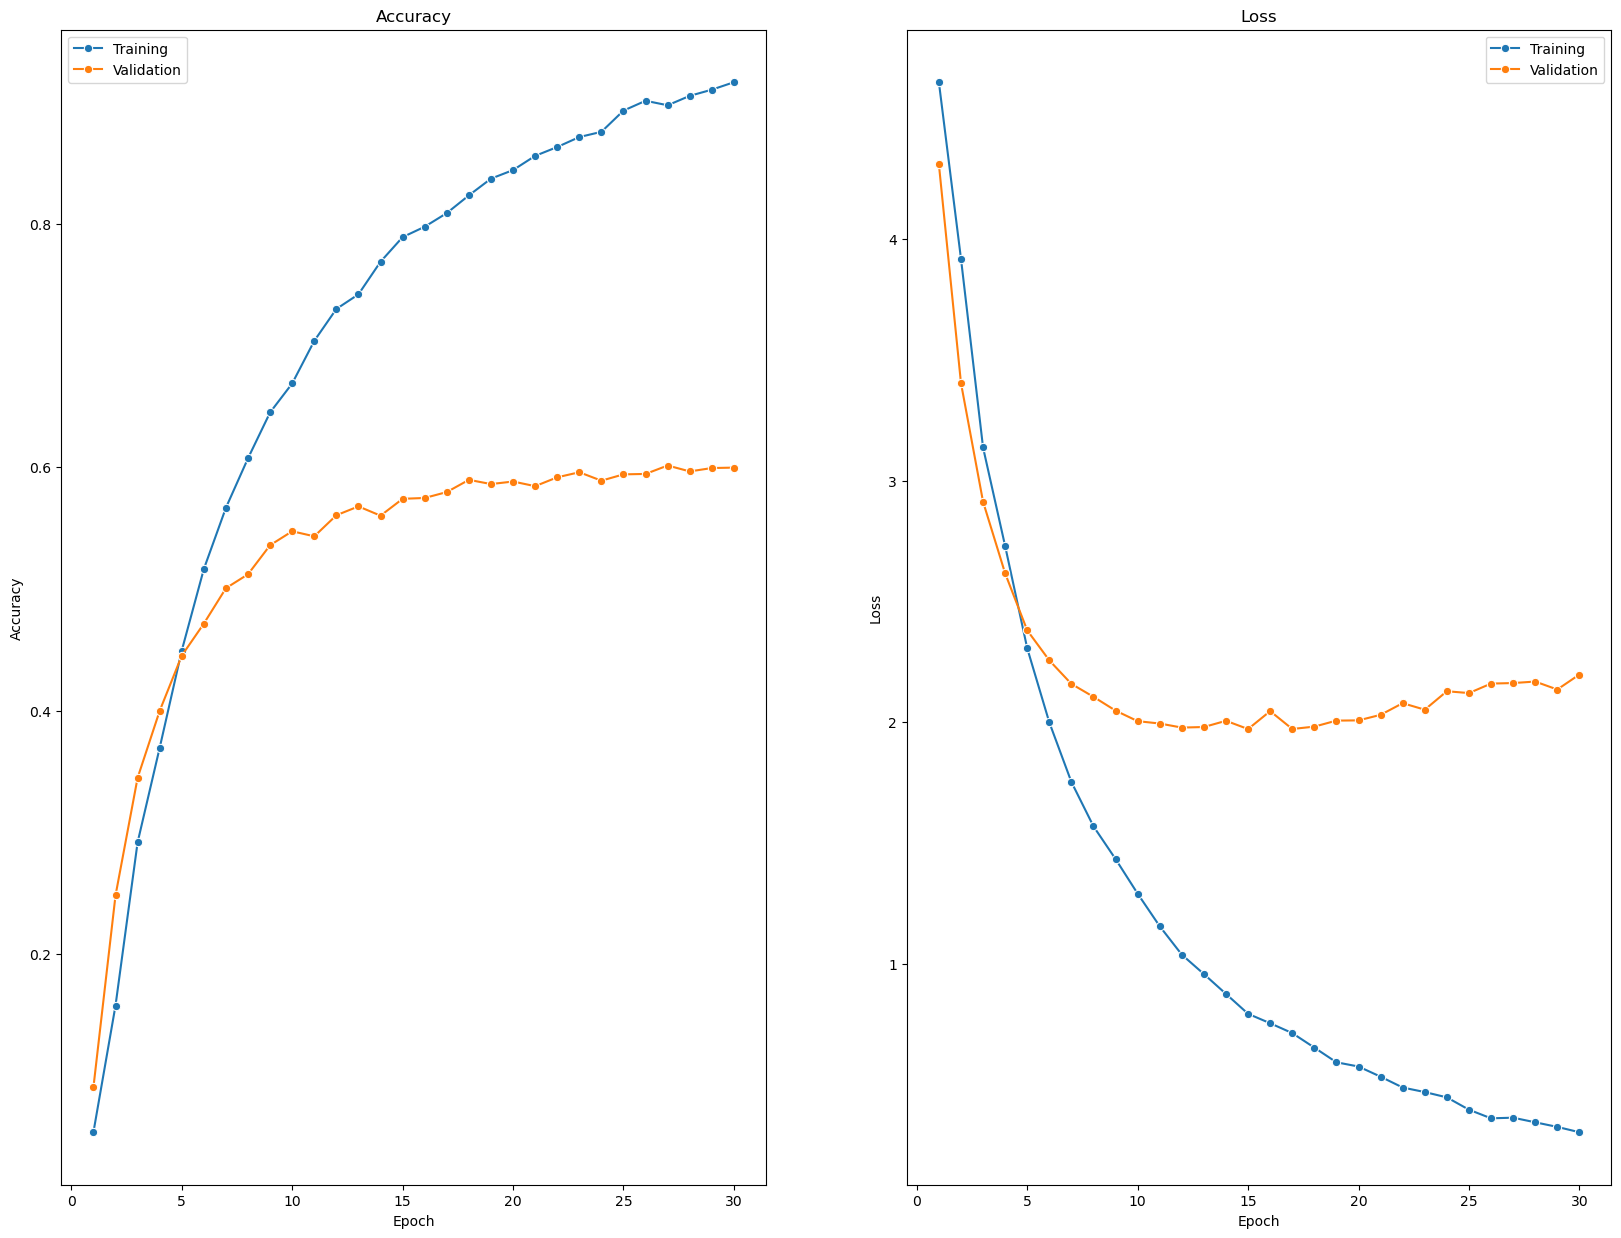

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (20,15))

# Accuracy plots
sns.lineplot(data = history_df, x = range(1,epochs_num + 1), y = 'accuracy', marker = 'o', label = 'Training', ax = axes[0])
sns.lineplot(data = history_df, x = range(1,epochs_num + 1), y = 'val_accuracy', marker = 'o', label = 'Validation', ax = axes[0])
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss plots
sns.lineplot(data = history_df, x = range(1,epochs_num + 1), y = 'loss', marker = 'o', label = 'Training', ax = axes[1])
sns.lineplot(data = history_df, x = range(1,epochs_num + 1), y = 'val_loss', marker = 'o', label = 'Validation', ax = axes[1])
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

# Model Usage


In [1]:
# Importing the dataset excel with all the setences to classify 
df = pd.read_excel(r'data/to_classify.xlsx')

In [3]:
# Importing the classifier

classifier_path = r'output\classifier.keras'
classifier = tf.keras.models.load_model(classifier_path)
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          934200    
                                                                 
 dropout (Dropout)           (None, 512, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 190)               38190     
                                                                 
Total params: 1,213,190
Trainable params: 1,213,190
Non-trainable params: 0
_________________________________________________________________


## Transformation and tokenization of the sentences

In [4]:
lemma = WordNetLemmatizer()
s_words = stopwords.words('english')


def cleaning(row):
    row = re.sub(r'http\S+', '', row)

    row = re.sub("[^a-zA-Z0-9]", " ", row)

    row = nltk.word_tokenize(row.lower())

    row = [lemma.lemmatize(word) for word in row]

    row = [word for word in row if word not in s_words]

    row = " ".join(row)
    return row

df['MB'] = df['text'].apply(cleaning)
            
voc_size = 9342
max_sent_length = 512

one_hot = [one_hot(words, voc_size) for words in df['MB']]
pad= pad_sequences(one_hot, padding = 'pre', maxlen = max_sent_length)

In [5]:
encoder = joblib.load(r'label_encoder.pkl')


# Build the dataset with the classification of the sentences in MITRE

_ = [[] for i in range(df.shape[0])]
df['classification'], df['classification_conf'] = _, _
prediction_sample= classifier(pad)
predictions_confidences = []
prob_tensor = tf.keras.activations.softmax(prediction_sample, axis = -1)


for index in range(df.shape[0]):
        top_k_probabilities, top_k_classes = tf.math.top_k(prob_tensor[index], k=5)
        attack_ids=[]
        probabilities=[]

        for classy in top_k_classes:
            attack_ids.append(str(encoder.inverse_transform([classy])[0]))

        for probability in top_k_probabilities:
            probabilities.append(np.round(float(probability), 4))

        df['classification'][index] = attack_ids
        df['classification_conf'][index] = probabilities


In [8]:
df.to_csv('output/classified_sentences.csv')

In [9]:
df

,text,MB,classification,classification_conf
0,"Since the original announcement, we have obser...",since original announcement observed several n...,"[T1189, T1080, T1001, T1480, T1059]","[0.0067, 0.0064, 0.006, 0.0056, 0.0056]"
1,"To compromise the victims, the attackers used ...",compromise victim attacker used extremely effe...,"[T1027, T1016, T1132, T1082, T1518]","[0.0126, 0.0057, 0.0053, 0.0052, 0.0052]"
2,The PDFs were highly relevant and well-crafted...,pdfs highly relevant well crafted content fabr...,"[T1187, T1555, T1110, T1003, T1558]","[0.0065, 0.006, 0.0058, 0.0057, 0.0057]"
3,These malicious PDF files were rigged with exp...,malicious pdf file rigged exploit attacking ad...,"[T1140, T1027, T1036, T1055, T1105]","[0.0135, 0.0054, 0.0052, 0.0052, 0.0052]"
4,"Once the system is exploited, a very small dow...",system exploited small downloader dropped onto...,"[T1027, T1140, T1573, T1001, T1482]","[0.0133, 0.0053, 0.0053, 0.0053, 0.0052]"
5,This downloader is unique per system and conta...,downloader unique per system contains customiz...,"[T1059, T1559, T1546, T1205, T1071]","[0.0116, 0.0062, 0.0053, 0.0053, 0.0053]"
6,"When loaded at system boot, the downloader use...",loaded system boot downloader us set mathemati...,"[T1553, T1027, T1106, T1562, T1548]","[0.0134, 0.0054, 0.0053, 0.0052, 0.0052]"
7,If the target system meets the pre-defined req...,target system meet pre defined requirement mal...,"[T1140, T1546, T1027, T1574, T1620]","[0.0118, 0.0059, 0.0053, 0.0053, 0.0053]"
8,These accounts were created by MiniDuke-s Comm...,account created miniduke command control c2 op...,"[T1547, T1546, T1012, T1218, T1037]","[0.0142, 0.0052, 0.0052, 0.0052, 0.0052]"
9,"These URLs provide access to the C2s, which th...",url provide access c2s provide potential comma...,"[T1056, T1003, T1562, T1112, T1070]","[0.0064, 0.0061, 0.0057, 0.0057, 0.0056]"
